# Garbage Classification

## Introduction


### Authors
Rene Lamb - A20457909

Nishanth Rao - A20466002

Jean Haberer - A20496422
### Description
In this paper we define "garbage" and "waste" as used items to be discarded within a trash bin. Our application utilizes a convolution neural network to classify garbage into eight classes: plastic, glass, metal, paper, cardboard, organic waste, E-waste, and chemical waste. There is a lot of diversity in shapes, colors, and sizes of garbage. For example, glass can come in the form of a bottle, cup, vase, etc. Organic waste can be a variety of different foods. Therefore, to solve the problem of identifying waste, we needed to develop a model that is able to identify key features that are common between items of the same class. Additionally, we needed to collect a large and diverse dataset of images so that this model can correctly learn those features.

## Data Processing

### Library Imports

In [ ]:
from google.colab import drive
from PIL import Image
import numpy as np
import pandas as pd
import os
import sklearn
import tensorflow
import sklearn.model_selection
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

### Data Frame Image Imports

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -uq '/content/drive/MyDrive/dataset.zip' -d 'dataout' # your location of the zip file needs to be put here
DATASET_PATH = 'dataout/dataset'

In [ ]:
dataset = pd.DataFrame()
for target_class in os.listdir(DATASET_PATH):
    temp = pd.DataFrame()
    i = 0
    if target_class != '.DS_Store':
        for photo in os.listdir(DATASET_PATH +'/'+ target_class): #added '/'
            temp.loc[i, 'path'] = DATASET_PATH + '/' + target_class + "/" + photo #added '/'
            temp.loc[i, 'class'] = target_class
            i += 1
        dataset = pd.concat([dataset, temp], ignore_index=True)
        del temp

In [ ]:
'''from sklearn.utils import resample
# Down sample the data 
def downsample_class(g_class,samples,data):
  df_majority = data.loc[data['class'] == g_class]
  df_minority = data.loc[data['class'] != g_class]
  df_majority_downsampled = resample(df_majority, replace=False, n_samples=samples)
  return pd.concat([df_majority_downsampled, df_minority])'''

"from sklearn.utils import resample\n# Down sample the data \ndef downsample_class(g_class,samples,data):\n  df_majority = data.loc[data['class'] == g_class]\n  df_minority = data.loc[data['class'] != g_class]\n  df_majority_downsampled = resample(df_majority, replace=False, n_samples=samples)\n  return pd.concat([df_majority_downsampled, df_minority])"

In [ ]:
'''g_labels = ["Glass","Paper","Organic","Chemical","Cardboard","Plastic","Metal","E-Waste"]
for label in g_labels:
  dataset = downsample_class(label,600,dataset)'''

'g_labels = ["Glass","Paper","Organic","Chemical","Cardboard","Plastic","Metal","E-Waste"]\nfor label in g_labels:\n  dataset = downsample_class(label,600,dataset)'

In [ ]:
dataset = dataset.sample(frac=1) #Shuffle the dataset
dataset.reset_index(drop=True, inplace=True)
print(dataset.head())
dataset['class'].value_counts()

                                        path      class
0         dataout/dataset/Metal/metal507.jpg      Metal
1         dataout/dataset/Metal/metal385.jpg      Metal
2         dataout/dataset/Metal/metal465.jpg      Metal
3  dataout/dataset/Cardboard/cardboard89.jpg  Cardboard
4   dataout/dataset/Glass/white-glass383.jpg      Glass


Paper        1050
Glass         987
Organic       985
Chemical      945
Cardboard     891
Plastic       865
Metal         769
E-Waste       622
Name: class, dtype: int64

### Training / Testing set splitting


In [ ]:
train_d, test_d = sklearn.model_selection.train_test_split(dataset, test_size=0.2, random_state=0, stratify=dataset['class'])
test_d.head()

path     class
950   dataout/dataset/Organic/biological790.jpg   Organic
6368   dataout/dataset/Glass/green-glass593.jpg     Glass
625     dataout/dataset/Chemical/battery851.jpg  Chemical
3359  dataout/dataset/Organic/biological796.jpg   Organic
1176   dataout/dataset/Glass/white-glass341.jpg     Glass

### Final Data set creation

In [ ]:
datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, fill_mode='nearest')
training_set = datagen.flow_from_dataframe(train_d, x_col="path", y_col="class", target_size = (256, 256), batch_size = 32, color_mode="rgb", class_mode = 'categorical')
testing_set = datagen.flow_from_dataframe(test_d, x_col="path", y_col="class", target_size = (256, 256), batch_size = 32, color_mode="rgb", class_mode = 'categorical')

labels = (training_set.class_indices)
labels = dict((v,k) for k,v in labels.items())

Found 5690 validated image filenames belonging to 8 classes.
Found 1423 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
import matplotlib.pyplot as plt

(32, 256, 256, 3)
Chemical


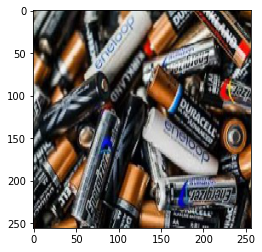

(32, 256, 256, 3)
Glass


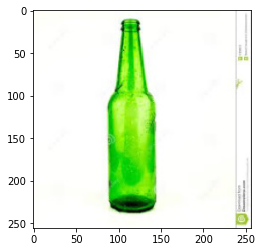

(32, 256, 256, 3)
Chemical


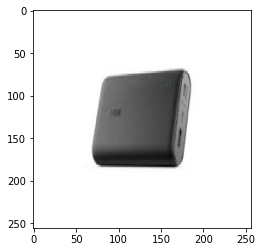

(32, 256, 256, 3)
Paper


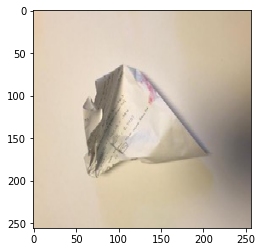

(32, 256, 256, 3)
Organic


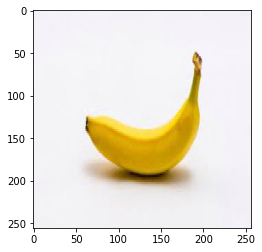

In [ ]:
%matplotlib inline

for _ in range(5):
    img, label = training_set.next()
    print(img.shape)   #  (1,256,256,3)
    print(labels[np.argmax(label[0])])
    plt.imshow(img[0])
    plt.show()

## Generate Model
######NOTE: In order to increase the speed of training, use GPU. To do this Select EDIT->Notebook Settings->GPU

In [ ]:
def cnn_model_3():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape= (256,256,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    # model.add(Dropout(0.3))          # Dropout did not increase the accuracy of the model
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2)))
    # model.add(Dropout(0.4))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2)))
    # model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(32, activation = 'relu'))
    model.add(BatchNormalization())
    # model.add(Dropout(0.2))
    model.add(Dense(16, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(8, activation = 'softmax'))
    # opt = tensorflow.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)  # Far too slow
    opt = tensorflow.keras.optimizers.Adagrad(learning_rate=0.001)              # best model
    # opt = tensorflow.keras.optimizers.Adadelta(learning_rate=0.001)           # not suitable
    model.compile(
        optimizer = opt,
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    )
    return model

In [ ]:
# Model Summary
model_test = cnn_model_3()
model_test.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 252, 252, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                        

Preparing the inputs and targets from the training set

In [ ]:
inputs = np.asarray(training_set.filepaths)
targets = np.asarray(training_set.classes)

data1 = dict(zip(inputs, targets))
data2 = data1.items()
data3 = np.array(list(data2))
validation_training_set = pd.DataFrame(data3, columns = ['path', 'class'])

## KFold Cross Validation

In [ ]:
kfold = sklearn.model_selection.KFold(n_splits=5, shuffle=True, random_state=91)
history = [None] * kfold.n_splits

In [ ]:
fold_no = 1
for train_i, test_i in kfold.split(validation_training_set):
    print('----------------------------------------------------------------------------------------------------------------------------------------')
    print(f'Training for fold {fold_no}')
    print('----------------------------------------------------------------------------------------------------------------------------------------')
    # Define the validation training set
    training_set_val = datagen.flow_from_dataframe(
        validation_training_set.iloc[train_i], 
        x_col='path', 
        y_col='class', 
        target_size=(256, 256), 
        batch_size=16, 
        color_mode="rgb", 
        class_mode = 'categorical'
    )
    # Define the validation testing set
    testing_set_val = datagen.flow_from_dataframe(
        validation_training_set.iloc[test_i],
        x_col='path',
        y_col='class',
        target_size=(256, 256),
        batch_size=16,
        color_mode="rgb",
        class_mode='categorical'
    )
    # select the model to train
    model_new = cnn_model_3()
    # Train the model
    history[fold_no-1]=model_new.fit_generator(
        training_set_val,
        validation_data = testing_set_val,
        steps_per_epoch = training_set_val.n//training_set_val.batch_size,
        validation_steps = testing_set_val.n//testing_set_val.batch_size,
        epochs=15
    )
    model_filepath = '/content/drive/MyDrive/garbage_cnn_weights_final_model_' + str(fold_no) + '.h5'
    # save the model
    model_new.save(model_filepath)
    # increment the fold number counter
    fold_no += 1

----------------------------------------------------------------------------------------------------------------------------------------
Training for fold 1
----------------------------------------------------------------------------------------------------------------------------------------
Found 4552 validated image filenames belonging to 8 classes.
Found 1138 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/15
284/284 [==============================] - 76s 219ms/step - loss: 1.3764 - accuracy: 0.5437 - val_loss: 2.1796 - val_accuracy: 0.1787
Epoch 2/15
284/284 [==============================] - 61s 214ms/step - loss: 1.0148 - accuracy: 0.6973 - val_loss: 1.2514 - val_accuracy: 0.5924
Epoch 3/15
284/284 [==============================] - 61s 214ms/step - loss: 0.8530 - accuracy: 0.7643 - val_loss: 1.0043 - val_accuracy: 0.6972
Epoch 4/15
284/284 [==============================] - 61s 214ms/step - loss: 0.7365 - accuracy: 0.8155 - val_loss: 0.9654 - val_accuracy: 0.7262
Epoch 5/15
284/284 [==============================] - 61s 214ms/step - loss: 0.6358 - accuracy: 0.8576 - val_loss: 0.9877 - val_accuracy: 0.7218
Epoch 6/15
284/284 [==============================] - 61s 214ms/step - loss: 0.5806 - accuracy: 0.8832 - val_loss: 0.9903 - val_accuracy: 0.7183
Epoch 7/15
284/284 [==============================] - 61s 214ms/step - loss: 0.5327 - accuracy: 0.9021 - val_loss: 0.9659 - val_ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/15
284/284 [==============================] - 63s 215ms/step - loss: 1.3942 - accuracy: 0.5362 - val_loss: 2.5065 - val_accuracy: 0.2403
Epoch 2/15
284/284 [==============================] - 61s 214ms/step - loss: 1.0633 - accuracy: 0.6706 - val_loss: 1.2578 - val_accuracy: 0.5836
Epoch 3/15
284/284 [==============================] - 61s 215ms/step - loss: 0.8792 - accuracy: 0.7429 - val_loss: 1.0124 - val_accuracy: 0.7025
Epoch 4/15
284/284 [==============================] - 61s 214ms/step - loss: 0.7463 - accuracy: 0.8067 - val_loss: 0.9492 - val_accuracy: 0.7174
Epoch 5/15
284/284 [==============================] - 61s 214ms/step - loss: 0.6491 - accuracy: 0.8501 - val_loss: 0.9779 - val_accuracy: 0.7245
Epoch 6/15
284/284 [==============================] - 61s 214ms/step - loss: 0.5634 - accuracy: 0.8832 - val_loss: 0.9595 - val_accuracy: 0.7104
Epoch 7/15
284/284 [==============================] - 61s 214ms/step - loss: 0.4998 - accuracy: 0.9065 - val_loss: 0.9708 - val_ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/15
284/284 [==============================] - 68s 233ms/step - loss: 1.2773 - accuracy: 0.5701 - val_loss: 2.3641 - val_accuracy: 0.1822
Epoch 2/15
284/284 [==============================] - 61s 214ms/step - loss: 0.9617 - accuracy: 0.7015 - val_loss: 1.2836 - val_accuracy: 0.5423
Epoch 3/15
284/284 [==============================] - 61s 214ms/step - loss: 0.8053 - accuracy: 0.7663 - val_loss: 0.9300 - val_accuracy: 0.7025
Epoch 4/15
284/284 [==============================] - 61s 214ms/step - loss: 0.5980 - accuracy: 0.8600 - val_loss: 0.8737 - val_accuracy: 0.7438
Epoch 6/15
284/284 [==============================] - 61s 214ms/step - loss: 0.5195 - accuracy: 0.8909 - val_loss: 0.8509 - val_accuracy: 0.7289
Epoch 7/15
284/284 [==============================] - 66s 233ms/step - loss: 0.4663 - accuracy: 0.9125 - val_loss: 0.8697 - val_accuracy: 0.7403
Epoch 8/15
284/284 [==============================] - 61s 214ms/step - loss: 0.4128 - accuracy: 0.9345 - val_loss: 0.8779 - val_ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/15
284/284 [==============================] - 63s 215ms/step - loss: 1.3708 - accuracy: 0.5476 - val_loss: 2.5610 - val_accuracy: 0.1461
Epoch 2/15
284/284 [==============================] - 61s 214ms/step - loss: 1.0169 - accuracy: 0.6944 - val_loss: 1.1116 - val_accuracy: 0.6637
Epoch 3/15
284/284 [==============================] - 61s 213ms/step - loss: 0.8589 - accuracy: 0.7643 - val_loss: 0.9834 - val_accuracy: 0.7060
Epoch 4/15
284/284 [==============================] - 61s 214ms/step - loss: 0.7521 - accuracy: 0.8146 - val_loss: 0.9120 - val_accuracy: 0.7394
Epoch 5/15
284/284 [==============================] - 61s 214ms/step - loss: 0.6408 - accuracy: 0.8642 - val_loss: 0.9341 - val_accuracy: 0.7324
Epoch 6/15
284/284 [==============================] - 61s 213ms/step - loss: 0.5584 - accuracy: 0.8966 - val_loss: 0.9359 - val_accuracy: 0.7254
Epoch 7/15
284/284 [==============================] - 61s 214ms/step - loss: 0.5043 - accuracy: 0.9169 - val_loss: 0.8869 - val_ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/15
284/284 [==============================] - 63s 216ms/step - loss: 1.3004 - accuracy: 0.5840 - val_loss: 2.2322 - val_accuracy: 0.1708
Epoch 2/15
284/284 [==============================] - 61s 214ms/step - loss: 0.9670 - accuracy: 0.7037 - val_loss: 1.2821 - val_accuracy: 0.5880
Epoch 3/15
284/284 [==============================] - 61s 214ms/step - loss: 0.8011 - accuracy: 0.7751 - val_loss: 0.8711 - val_accuracy: 0.7403
Epoch 4/15
284/284 [==============================] - 61s 214ms/step - loss: 0.6743 - accuracy: 0.8263 - val_loss: 0.8419 - val_accuracy: 0.7482
Epoch 5/15
284/284 [==============================] - 61s 215ms/step - loss: 0.5768 - accuracy: 0.8693 - val_loss: 0.8464 - val_accuracy: 0.7482
Epoch 6/15
284/284 [==============================] - 61s 214ms/step - loss: 0.4982 - accuracy: 0.9039 - val_loss: 0.8642 - val_accuracy: 0.7491
Epoch 7/15
284/284 [==============================] - 61s 215ms/step - loss: 0.4390 - accuracy: 0.9299 - val_loss: 0.8843 - val_ac

for fold number 1:


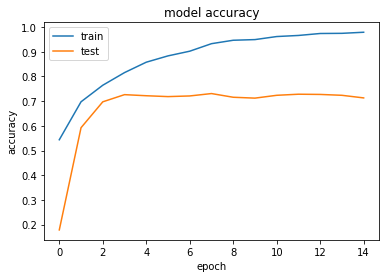

for fold number 2:


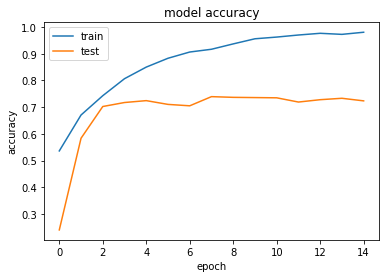

for fold number 3:


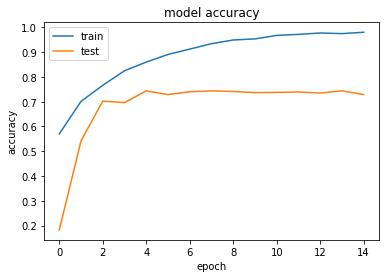

for fold number 4:


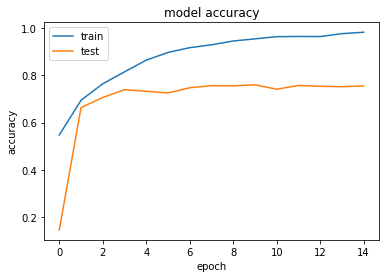

for fold number 5:


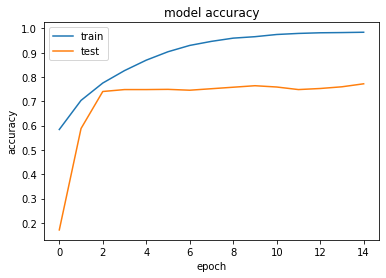

In [ ]:
fold = 1
for h in history:
    print(f'for fold number {fold}:')
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fold += 1

for fold number 1:


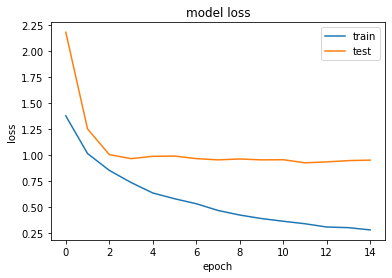

for fold number 2:


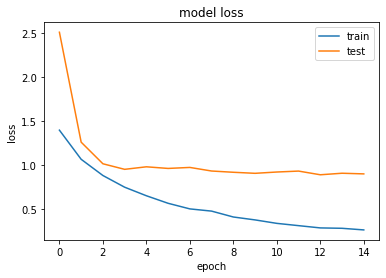

for fold number 3:


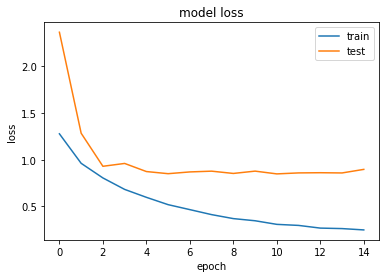

for fold number 4:


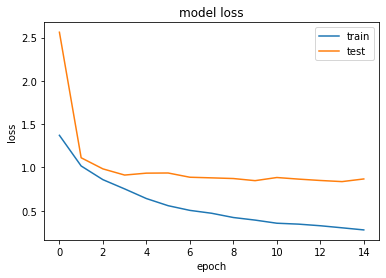

for fold number 5:


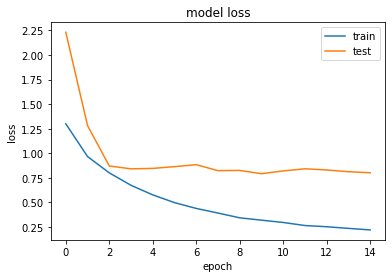

In [ ]:
fold = 1
for h in history:
    print(f'for fold number {fold}:')
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    fold += 1

# Model Testing

In [ ]:
from tensorflow.keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [ ]:
# load the four models
loaded_model_1 = load_model('/content/drive/MyDrive/garbage_cnn_weights_final_model_1.h5')
loaded_model_2 = load_model('/content/drive/MyDrive/garbage_cnn_weights_final_model_2.h5')
loaded_model_3 = load_model('/content/drive/MyDrive/garbage_cnn_weights_final_model_3.h5')
loaded_model_4 = load_model('/content/drive/MyDrive/garbage_cnn_weights_final_model_4.h5')
loaded_model_5 = load_model('/content/drive/MyDrive/garbage_cnn_weights_final_model_5.h5')

In [ ]:
# print the accuracy and loss of the evaluations
print(loaded_model_1.evaluate_generator(testing_set, verbose=2))
print(loaded_model_2.evaluate_generator(testing_set, verbose=2))
print(loaded_model_3.evaluate_generator(testing_set, verbose=2))
print(loaded_model_4.evaluate_generator(testing_set, verbose=2))
print(loaded_model_5.evaluate_generator(testing_set, verbose=2))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


45/45 - 10s - loss: 0.8784 - accuracy: 0.7330 - 10s/epoch - 228ms/step
[0.8784439563751221, 0.7329585552215576]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


45/45 - 6s - loss: 0.8676 - accuracy: 0.7273 - 6s/epoch - 143ms/step
[0.8676043152809143, 0.727336585521698]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  after removing the cwd from sys.path.


45/45 - 6s - loss: 0.9068 - accuracy: 0.7238 - 6s/epoch - 144ms/step
[0.9068291187286377, 0.7238228917121887]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """


45/45 - 6s - loss: 0.8823 - accuracy: 0.7407 - 6s/epoch - 143ms/step
[0.8822697401046753, 0.740688681602478]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


45/45 - 6s - loss: 0.8125 - accuracy: 0.7533 - 6s/epoch - 143ms/step
[0.8125404119491577, 0.7533380389213562]


Accuracy on unseen dataset here is about 70% - 75%.

In [ ]:
y_pred_1 = loaded_model_1.predict_generator(testing_set, verbose=2)
y_pred_2 = loaded_model_2.predict_generator(testing_set, verbose=2)
y_pred_3 = loaded_model_3.predict_generator(testing_set, verbose=2)
y_pred_4 = loaded_model_4.predict_generator(testing_set, verbose=2)
y_pred_5 = loaded_model_5.predict_generator(testing_set, verbose=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


45/45 - 6s - 6s/epoch - 142ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


45/45 - 6s - 6s/epoch - 141ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


45/45 - 6s - 6s/epoch - 142ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


45/45 - 6s - 6s/epoch - 141ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


45/45 - 6s - 6s/epoch - 142ms/step


In [ ]:
predictions_1 = [np.argmax(y_pred_1[i]) for i in range(len(y_pred_1))]
predictions_2 = [np.argmax(y_pred_2[i]) for i in range(len(y_pred_2))]
predictions_3 = [np.argmax(y_pred_3[i]) for i in range(len(y_pred_3))]
predictions_4 = [np.argmax(y_pred_4[i]) for i in range(len(y_pred_4))]
predictions_5 = [np.argmax(y_pred_5[i]) for i in range(len(y_pred_5))]

###Confusion matrix

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [ ]:
# actual classes
print(testing_set.classes)
# predicted classes
print(predictions_1)
print(predictions_2)
print(predictions_3)
print(predictions_4)
print(predictions_5)

[5, 3, 1, 5, 3, 5, 7, 6, 1, 3, 5, 0, 3, 1, 7, 1, 0, 4, 3, 1, 4, 7, 2, 4, 6, 2, 3, 6, 3, 5, 6, 6, 6, 3, 1, 7, 3, 0, 6, 1, 6, 3, 6, 1, 6, 0, 6, 6, 0, 3, 7, 7, 5, 3, 3, 3, 0, 5, 6, 0, 1, 4, 6, 1, 4, 7, 0, 6, 5, 2, 0, 7, 5, 7, 6, 5, 0, 2, 5, 2, 6, 3, 6, 1, 6, 3, 6, 6, 4, 3, 4, 3, 6, 2, 3, 7, 3, 1, 1, 1, 6, 6, 0, 2, 2, 6, 5, 3, 4, 7, 7, 3, 6, 6, 1, 3, 3, 4, 0, 6, 3, 6, 0, 5, 0, 7, 0, 3, 3, 5, 5, 0, 1, 1, 5, 0, 4, 1, 1, 6, 7, 5, 0, 5, 5, 3, 6, 3, 4, 3, 2, 1, 7, 6, 4, 0, 7, 7, 3, 1, 6, 5, 1, 0, 6, 3, 3, 2, 5, 2, 4, 1, 0, 2, 6, 1, 7, 6, 5, 4, 6, 4, 3, 0, 6, 7, 2, 3, 0, 0, 7, 1, 0, 4, 3, 2, 7, 4, 2, 3, 0, 4, 6, 1, 2, 1, 0, 6, 3, 0, 3, 1, 5, 5, 7, 2, 0, 7, 0, 6, 4, 6, 5, 5, 1, 1, 5, 4, 7, 6, 7, 7, 4, 1, 7, 3, 3, 6, 1, 4, 2, 3, 4, 3, 1, 0, 0, 4, 3, 1, 3, 6, 1, 7, 7, 1, 0, 4, 2, 4, 1, 5, 2, 7, 7, 7, 6, 3, 3, 1, 0, 2, 2, 4, 1, 7, 4, 4, 0, 2, 5, 6, 1, 7, 4, 6, 4, 6, 6, 5, 7, 1, 1, 0, 7, 6, 6, 6, 1, 4, 0, 5, 4, 1, 5, 3, 5, 1, 2, 7, 2, 7, 2, 5, 3, 2, 2, 5, 7, 6, 0, 7, 2, 0, 1, 7, 1, 6, 0, 2, 6, 1, 7, 

In [ ]:
conf_matrix_1 = confusion_matrix(testing_set.classes, predictions_1)
conf_matrix_2 = confusion_matrix(testing_set.classes, predictions_2)
conf_matrix_3 = confusion_matrix(testing_set.classes, predictions_3)
conf_matrix_4 = confusion_matrix(testing_set.classes, predictions_4)
conf_matrix_5 = confusion_matrix(testing_set.classes, predictions_5)

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f281cc57c90>)

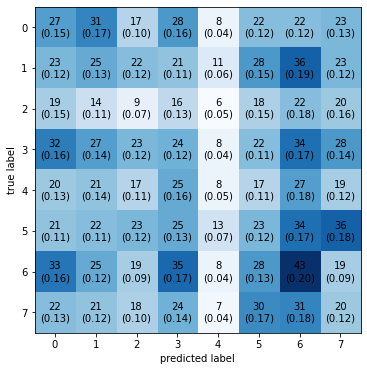

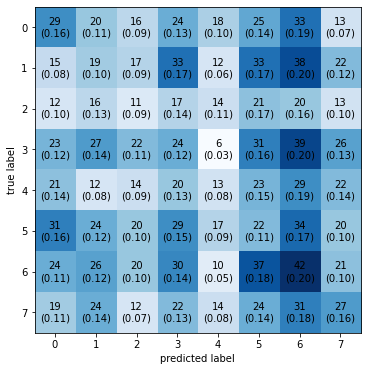

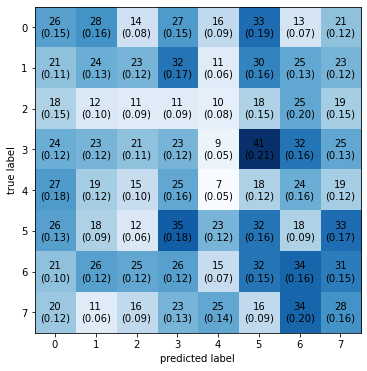

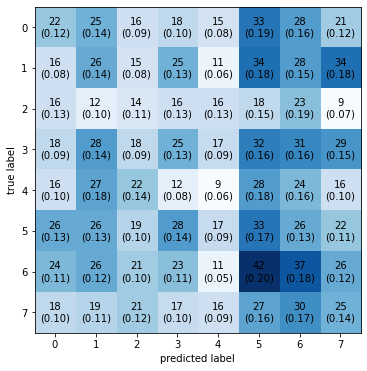

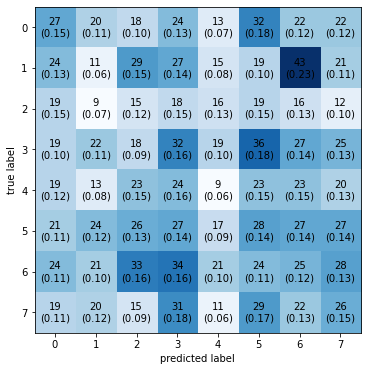

In [ ]:
plot_confusion_matrix(conf_matrix_1, show_normed=True, figsize=(6,6))
plot_confusion_matrix(conf_matrix_2, show_normed=True, figsize=(6,6))
plot_confusion_matrix(conf_matrix_3, show_normed=True, figsize=(6,6))
plot_confusion_matrix(conf_matrix_4, show_normed=True, figsize=(6,6))
plot_confusion_matrix(conf_matrix_5, show_normed=True, figsize=(6,6))

## Let's see how it does on some home made samples

In [ ]:
SAMPLE_SET_PATH = '/content/drive/MyDrive/sample_set/'

In [ ]:
sample_dataset_paths = pd.DataFrame()
sample_set_size = 0
for photo in os.listdir(SAMPLE_SET_PATH):
  sample_dataset_paths.loc[sample_set_size, 'path'] = SAMPLE_SET_PATH + photo
  sample_dataset_paths.loc[sample_set_size, 'class'] = 'unknown'
  sample_set_size += 1

print(sample_dataset_paths)

                                                 path    class
0         /content/drive/MyDrive/sample_set/Phone.jpg  unknown
1   /content/drive/MyDrive/sample_set/Electric_TB.jpg  unknown
2          /content/drive/MyDrive/sample_set/Rene.jpg  unknown
3       /content/drive/MyDrive/sample_set/Wood_TB.jpg  unknown
4         /content/drive/MyDrive/sample_set/Macdo.jpg  unknown
5         /content/drive/MyDrive/sample_set/Paper.jpg  unknown
6      /content/drive/MyDrive/sample_set/Wrapping.jpg  unknown
7   /content/drive/MyDrive/sample_set/Another Wood...  unknown
8         /content/drive/MyDrive/sample_set/Vodka.jpg  unknown
9       /content/drive/MyDrive/sample_set/Nisanth.jpg  unknown
10         /content/drive/MyDrive/sample_set/Jean.jpg  unknown
11         /content/drive/MyDrive/sample_set/Wine.jpg  unknown
12           /content/drive/MyDrive/sample_set/N3.jpg  unknown
13           /content/drive/MyDrive/sample_set/N1.jpg  unknown
14           /content/drive/MyDrive/sample_set/N2.jpg  

In [ ]:
sample_set_gen = datagen.flow_from_dataframe(sample_dataset_paths, x_col="path", y_col="class", target_size = (256, 256), color_mode="rgb", class_mode = 'categorical')

Found 16 validated image filenames belonging to 1 classes.


In [ ]:
sample_set = sample_set_gen.next()[0]

In [ ]:
sample_predictions_1 = loaded_model_1.predict_generator(sample_set)
sample_predictions_2 = loaded_model_2.predict_generator(sample_set)
sample_predictions_3 = loaded_model_3.predict_generator(sample_set)
sample_predictions_4 = loaded_model_4.predict_generator(sample_set)
sample_predictions_5 = loaded_model_5.predict_generator(sample_set)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after remov

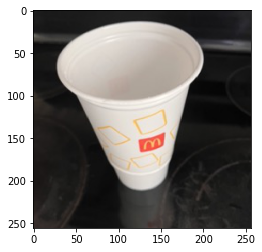

Cardboard 1%
Chemical 11%
E-Waste 2%
Glass 3%
Metal 5%
Organic 68%
Paper 7%
Plastic 1%

RESULT:
Organic
––––––––––––––––


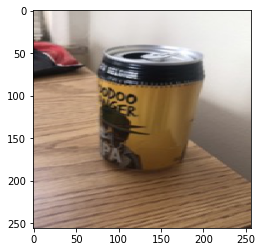

Cardboard 47%
Chemical 6%
E-Waste 6%
Glass 14%
Metal 3%
Organic 12%
Paper 6%
Plastic 6%

RESULT:
Cardboard
––––––––––––––––


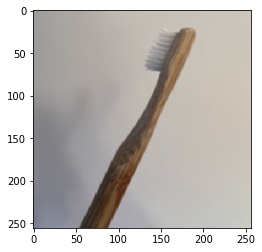

Cardboard 12%
Chemical 3%
E-Waste 7%
Glass 23%
Metal 13%
Organic 3%
Paper 1%
Plastic 38%

RESULT:
Plastic
––––––––––––––––


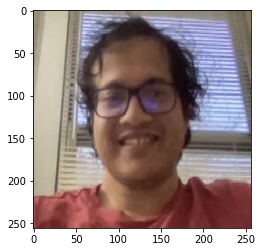

Cardboard 33%
Chemical 4%
E-Waste 6%
Glass 29%
Metal 1%
Organic 2%
Paper 22%
Plastic 3%

RESULT:
Cardboard
––––––––––––––––


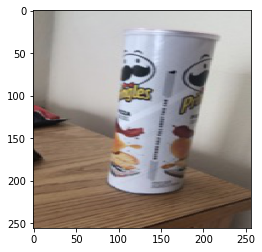

Cardboard 2%
Chemical 6%
E-Waste 45%
Glass 4%
Metal 1%
Organic 1%
Paper 2%
Plastic 39%

RESULT:
E-Waste
––––––––––––––––


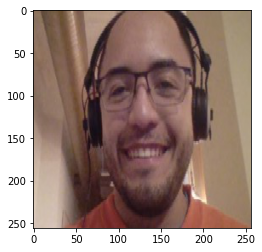

Cardboard 4%
Chemical 13%
E-Waste 6%
Glass 9%
Metal 41%
Organic 21%
Paper 5%
Plastic 1%

RESULT:
Metal
––––––––––––––––


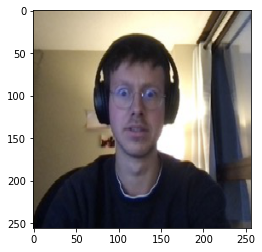

Cardboard 9%
Chemical 20%
E-Waste 24%
Glass 7%
Metal 7%
Organic 11%
Paper 17%
Plastic 6%

RESULT:
E-Waste
––––––––––––––––


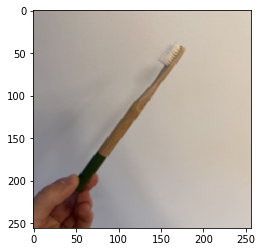

Cardboard 8%
Chemical 2%
E-Waste 6%
Glass 18%
Metal 9%
Organic 2%
Paper 3%
Plastic 52%

RESULT:
Plastic
––––––––––––––––


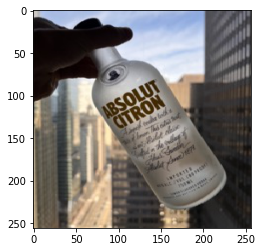

Cardboard 4%
Chemical 5%
E-Waste 10%
Glass 0%
Metal 3%
Organic 73%
Paper 2%
Plastic 3%

RESULT:
Organic
––––––––––––––––


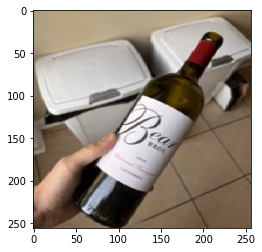

Cardboard 15%
Chemical 23%
E-Waste 7%
Glass 15%
Metal 1%
Organic 5%
Paper 15%
Plastic 19%

RESULT:
Chemical
––––––––––––––––


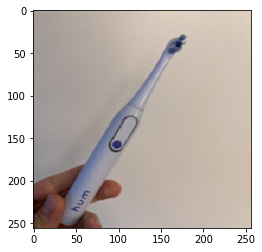

Cardboard 5%
Chemical 2%
E-Waste 4%
Glass 13%
Metal 11%
Organic 1%
Paper 2%
Plastic 62%

RESULT:
Plastic
––––––––––––––––


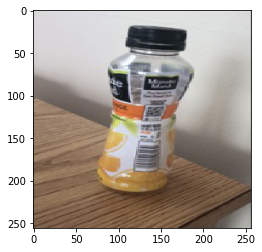

Cardboard 12%
Chemical 14%
E-Waste 15%
Glass 15%
Metal 1%
Organic 7%
Paper 11%
Plastic 25%

RESULT:
Plastic
––––––––––––––––


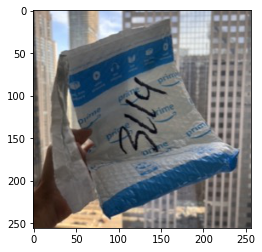

Cardboard 2%
Chemical 2%
E-Waste 60%
Glass 2%
Metal 4%
Organic 0%
Paper 3%
Plastic 26%

RESULT:
E-Waste
––––––––––––––––


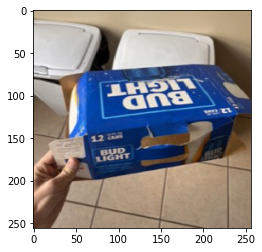

Cardboard 2%
Chemical 14%
E-Waste 32%
Glass 5%
Metal 7%
Organic 1%
Paper 9%
Plastic 29%

RESULT:
E-Waste
––––––––––––––––


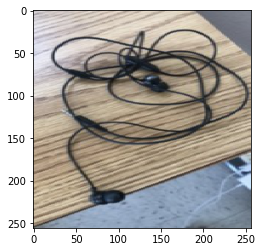

Cardboard 7%
Chemical 2%
E-Waste 2%
Glass 2%
Metal 2%
Organic 3%
Paper 79%
Plastic 3%

RESULT:
Paper
––––––––––––––––


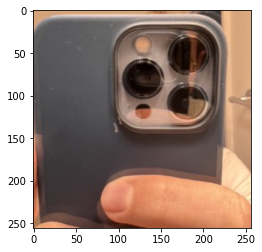

Cardboard 17%
Chemical 13%
E-Waste 30%
Glass 6%
Metal 5%
Organic 6%
Paper 6%
Plastic 16%

RESULT:
E-Waste
––––––––––––––––


In [ ]:
for i in range(sample_set_size):
    img = sample_set[i]
    plt.imshow(img)
    plt.show()
    for label_i in range(len(labels)):
      print(labels[label_i], "{0:.0%}".format(sample_predictions_1[i, label_i]))
    print()
    print("RESULT:")
    print(labels[np.argmax(sample_predictions_1[i])])
    print("––––––––––––––––")

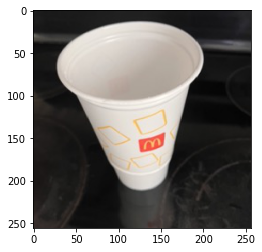

Cardboard 9%
Chemical 3%
E-Waste 1%
Glass 2%
Metal 0%
Organic 78%
Paper 1%
Plastic 5%

RESULT:
Organic
––––––––––––––––


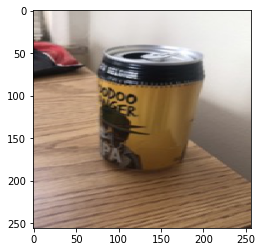

Cardboard 33%
Chemical 2%
E-Waste 17%
Glass 14%
Metal 17%
Organic 3%
Paper 5%
Plastic 10%

RESULT:
Cardboard
––––––––––––––––


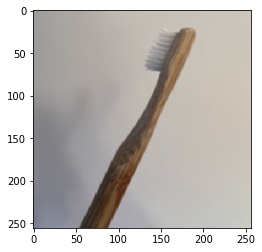

Cardboard 1%
Chemical 1%
E-Waste 4%
Glass 15%
Metal 5%
Organic 1%
Paper 1%
Plastic 72%

RESULT:
Plastic
––––––––––––––––


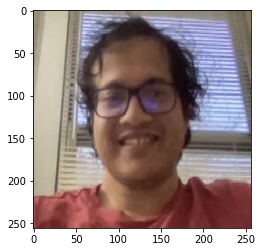

Cardboard 19%
Chemical 3%
E-Waste 4%
Glass 21%
Metal 3%
Organic 8%
Paper 36%
Plastic 8%

RESULT:
Paper
––––––––––––––––


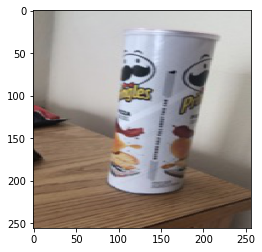

Cardboard 7%
Chemical 2%
E-Waste 3%
Glass 7%
Metal 2%
Organic 9%
Paper 2%
Plastic 67%

RESULT:
Plastic
––––––––––––––––


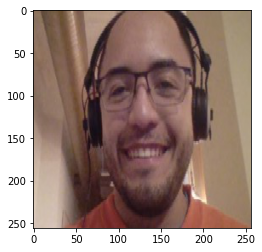

Cardboard 5%
Chemical 4%
E-Waste 9%
Glass 2%
Metal 3%
Organic 48%
Paper 3%
Plastic 26%

RESULT:
Organic
––––––––––––––––


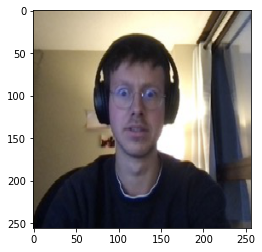

Cardboard 6%
Chemical 20%
E-Waste 5%
Glass 3%
Metal 53%
Organic 3%
Paper 8%
Plastic 1%

RESULT:
Metal
––––––––––––––––


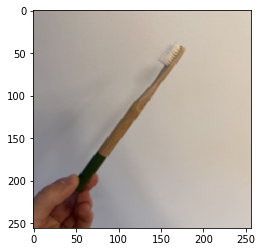

Cardboard 1%
Chemical 1%
E-Waste 3%
Glass 42%
Metal 2%
Organic 4%
Paper 1%
Plastic 45%

RESULT:
Plastic
––––––––––––––––


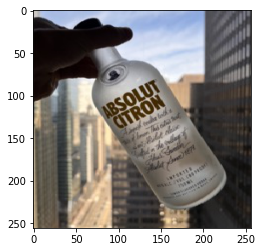

Cardboard 2%
Chemical 1%
E-Waste 2%
Glass 1%
Metal 4%
Organic 72%
Paper 3%
Plastic 15%

RESULT:
Organic
––––––––––––––––


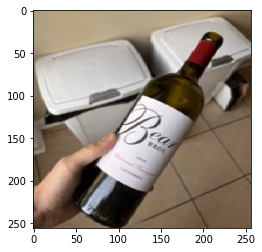

Cardboard 16%
Chemical 3%
E-Waste 3%
Glass 3%
Metal 5%
Organic 10%
Paper 5%
Plastic 55%

RESULT:
Plastic
––––––––––––––––


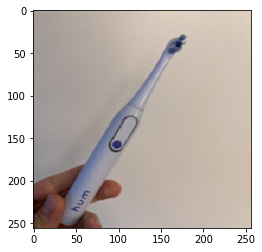

Cardboard 1%
Chemical 1%
E-Waste 6%
Glass 24%
Metal 9%
Organic 2%
Paper 1%
Plastic 56%

RESULT:
Plastic
––––––––––––––––


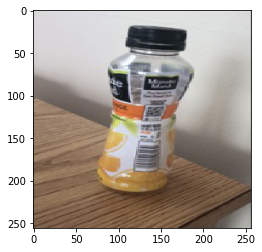

Cardboard 11%
Chemical 8%
E-Waste 10%
Glass 11%
Metal 11%
Organic 6%
Paper 8%
Plastic 35%

RESULT:
Plastic
––––––––––––––––


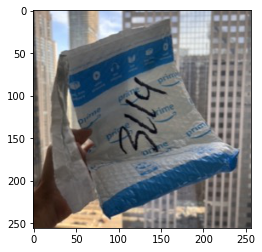

Cardboard 0%
Chemical 9%
E-Waste 53%
Glass 1%
Metal 4%
Organic 1%
Paper 22%
Plastic 8%

RESULT:
E-Waste
––––––––––––––––


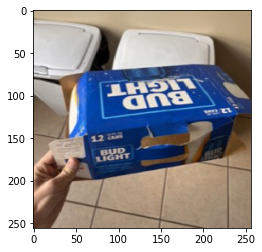

Cardboard 0%
Chemical 20%
E-Waste 29%
Glass 0%
Metal 7%
Organic 3%
Paper 39%
Plastic 2%

RESULT:
Paper
––––––––––––––––


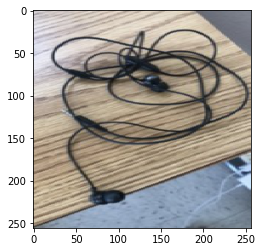

Cardboard 1%
Chemical 5%
E-Waste 6%
Glass 1%
Metal 9%
Organic 10%
Paper 62%
Plastic 6%

RESULT:
Paper
––––––––––––––––


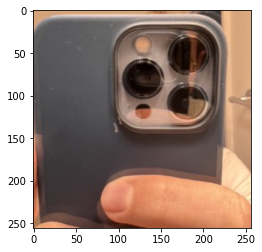

Cardboard 3%
Chemical 3%
E-Waste 55%
Glass 5%
Metal 8%
Organic 11%
Paper 5%
Plastic 10%

RESULT:
E-Waste
––––––––––––––––


In [ ]:
for i in range(sample_set_size):
    img = sample_set[i]
    plt.imshow(img)
    plt.show()
    for label_i in range(len(labels)):
      print(labels[label_i], "{0:.0%}".format(sample_predictions_2[i, label_i]))
    print()
    print("RESULT:")
    print(labels[np.argmax(sample_predictions_2[i])])
    print("––––––––––––––––")

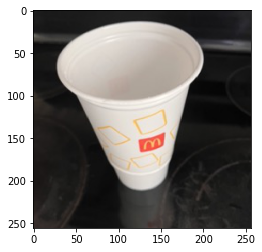

Cardboard 9%
Chemical 1%
E-Waste 10%
Glass 1%
Metal 1%
Organic 65%
Paper 11%
Plastic 2%

RESULT:
Organic
––––––––––––––––


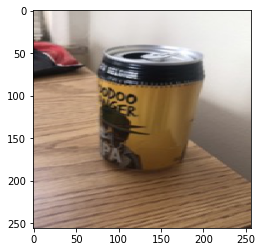

Cardboard 59%
Chemical 6%
E-Waste 13%
Glass 6%
Metal 5%
Organic 7%
Paper 1%
Plastic 3%

RESULT:
Cardboard
––––––––––––––––


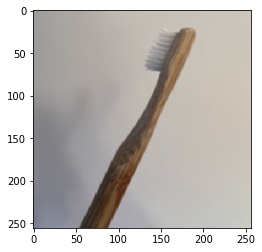

Cardboard 2%
Chemical 4%
E-Waste 9%
Glass 2%
Metal 3%
Organic 2%
Paper 2%
Plastic 74%

RESULT:
Plastic
––––––––––––––––


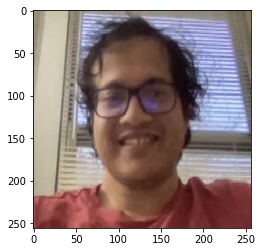

Cardboard 9%
Chemical 1%
E-Waste 2%
Glass 3%
Metal 9%
Organic 7%
Paper 69%
Plastic 1%

RESULT:
Paper
––––––––––––––––


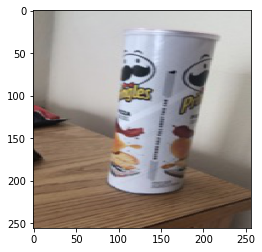

Cardboard 2%
Chemical 12%
E-Waste 20%
Glass 0%
Metal 0%
Organic 9%
Paper 1%
Plastic 56%

RESULT:
Plastic
––––––––––––––––


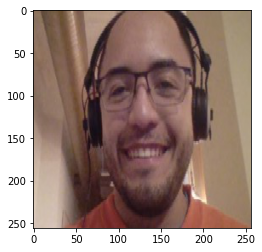

Cardboard 14%
Chemical 9%
E-Waste 25%
Glass 3%
Metal 2%
Organic 27%
Paper 2%
Plastic 19%

RESULT:
Organic
––––––––––––––––


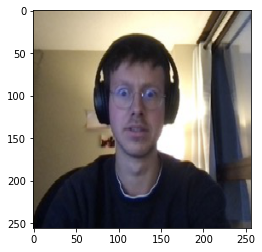

Cardboard 3%
Chemical 10%
E-Waste 69%
Glass 1%
Metal 4%
Organic 7%
Paper 0%
Plastic 6%

RESULT:
E-Waste
––––––––––––––––


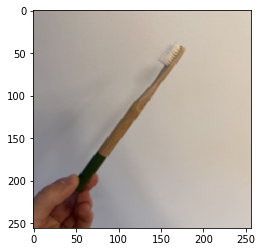

Cardboard 5%
Chemical 8%
E-Waste 11%
Glass 4%
Metal 21%
Organic 3%
Paper 5%
Plastic 43%

RESULT:
Plastic
––––––––––––––––


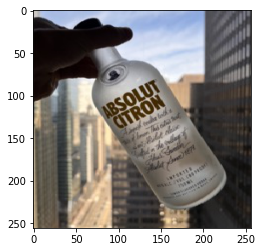

Cardboard 11%
Chemical 3%
E-Waste 10%
Glass 2%
Metal 29%
Organic 20%
Paper 20%
Plastic 4%

RESULT:
Metal
––––––––––––––––


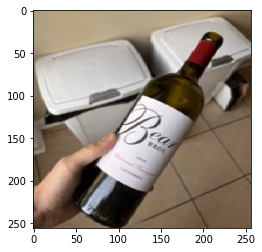

Cardboard 2%
Chemical 5%
E-Waste 2%
Glass 1%
Metal 0%
Organic 19%
Paper 13%
Plastic 58%

RESULT:
Plastic
––––––––––––––––


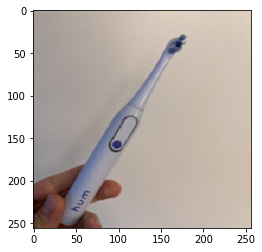

Cardboard 1%
Chemical 2%
E-Waste 8%
Glass 2%
Metal 3%
Organic 1%
Paper 4%
Plastic 78%

RESULT:
Plastic
––––––––––––––––


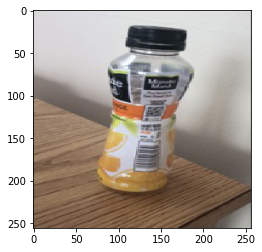

Cardboard 6%
Chemical 16%
E-Waste 14%
Glass 12%
Metal 12%
Organic 11%
Paper 7%
Plastic 21%

RESULT:
Plastic
––––––––––––––––


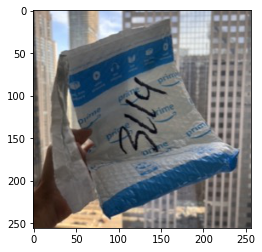

Cardboard 1%
Chemical 56%
E-Waste 11%
Glass 1%
Metal 5%
Organic 7%
Paper 3%
Plastic 17%

RESULT:
Chemical
––––––––––––––––


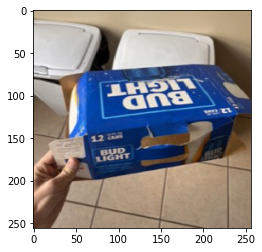

Cardboard 6%
Chemical 23%
E-Waste 14%
Glass 17%
Metal 18%
Organic 3%
Paper 7%
Plastic 12%

RESULT:
Chemical
––––––––––––––––


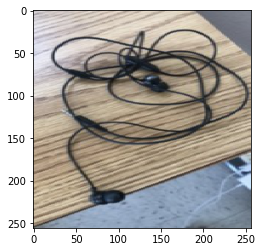

Cardboard 27%
Chemical 1%
E-Waste 11%
Glass 11%
Metal 10%
Organic 7%
Paper 29%
Plastic 3%

RESULT:
Paper
––––––––––––––––


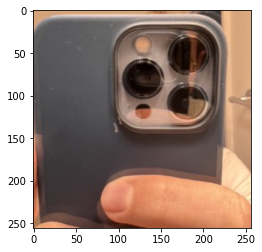

Cardboard 5%
Chemical 6%
E-Waste 79%
Glass 1%
Metal 3%
Organic 2%
Paper 0%
Plastic 5%

RESULT:
E-Waste
––––––––––––––––


In [ ]:
for i in range(sample_set_size):
    img = sample_set[i]
    plt.imshow(img)
    plt.show()
    for label_i in range(len(labels)):
      print(labels[label_i], "{0:.0%}".format(sample_predictions_3[i, label_i]))
    print()
    print("RESULT:")
    print(labels[np.argmax(sample_predictions_3[i])])
    print("––––––––––––––––")

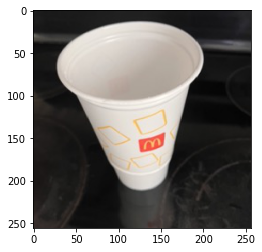

Cardboard 2%
Chemical 10%
E-Waste 20%
Glass 2%
Metal 3%
Organic 36%
Paper 9%
Plastic 18%

RESULT:
Organic
––––––––––––––––


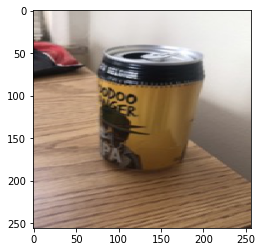

Cardboard 60%
Chemical 11%
E-Waste 4%
Glass 3%
Metal 3%
Organic 11%
Paper 4%
Plastic 3%

RESULT:
Cardboard
––––––––––––––––


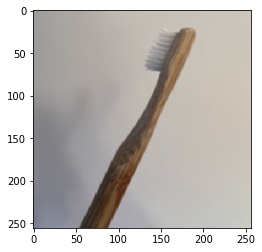

Cardboard 1%
Chemical 2%
E-Waste 23%
Glass 6%
Metal 34%
Organic 0%
Paper 0%
Plastic 35%

RESULT:
Plastic
––––––––––––––––


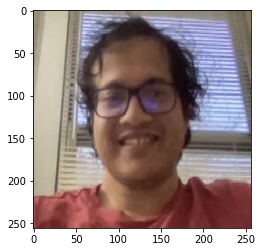

Cardboard 7%
Chemical 2%
E-Waste 6%
Glass 4%
Metal 4%
Organic 33%
Paper 40%
Plastic 4%

RESULT:
Paper
––––––––––––––––


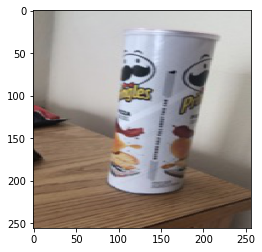

Cardboard 2%
Chemical 27%
E-Waste 28%
Glass 5%
Metal 3%
Organic 3%
Paper 1%
Plastic 32%

RESULT:
Plastic
––––––––––––––––


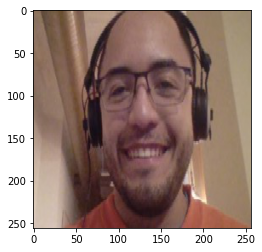

Cardboard 4%
Chemical 3%
E-Waste 10%
Glass 9%
Metal 10%
Organic 35%
Paper 4%
Plastic 24%

RESULT:
Organic
––––––––––––––––


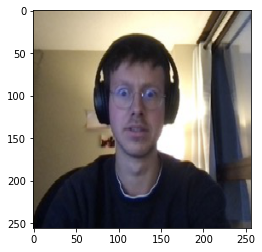

Cardboard 1%
Chemical 10%
E-Waste 35%
Glass 1%
Metal 10%
Organic 3%
Paper 2%
Plastic 39%

RESULT:
Plastic
––––––––––––––––


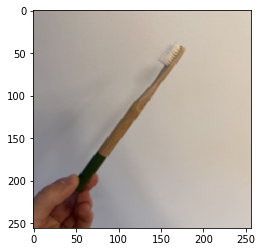

Cardboard 8%
Chemical 13%
E-Waste 33%
Glass 7%
Metal 11%
Organic 3%
Paper 3%
Plastic 22%

RESULT:
E-Waste
––––––––––––––––


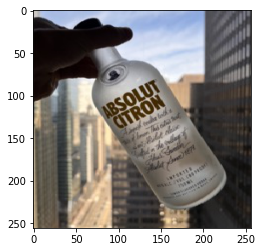

Cardboard 3%
Chemical 4%
E-Waste 9%
Glass 2%
Metal 15%
Organic 14%
Paper 26%
Plastic 26%

RESULT:
Plastic
––––––––––––––––


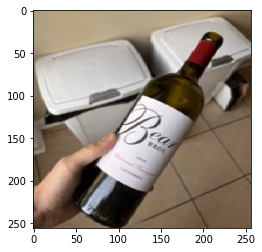

Cardboard 6%
Chemical 24%
E-Waste 9%
Glass 4%
Metal 8%
Organic 10%
Paper 5%
Plastic 34%

RESULT:
Plastic
––––––––––––––––


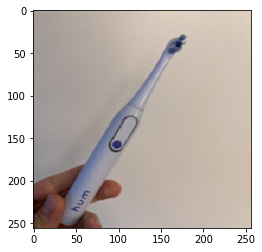

Cardboard 0%
Chemical 2%
E-Waste 18%
Glass 3%
Metal 11%
Organic 0%
Paper 0%
Plastic 65%

RESULT:
Plastic
––––––––––––––––


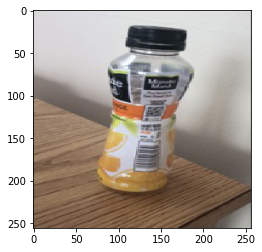

Cardboard 2%
Chemical 32%
E-Waste 38%
Glass 2%
Metal 1%
Organic 2%
Paper 2%
Plastic 21%

RESULT:
E-Waste
––––––––––––––––


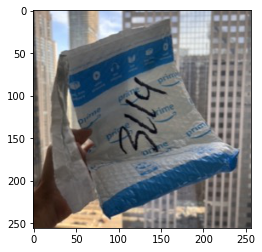

Cardboard 1%
Chemical 17%
E-Waste 35%
Glass 7%
Metal 17%
Organic 3%
Paper 5%
Plastic 17%

RESULT:
E-Waste
––––––––––––––––


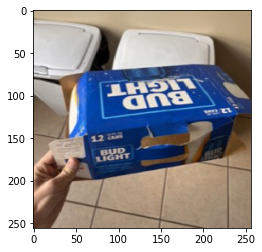

Cardboard 0%
Chemical 2%
E-Waste 61%
Glass 0%
Metal 3%
Organic 7%
Paper 16%
Plastic 10%

RESULT:
E-Waste
––––––––––––––––


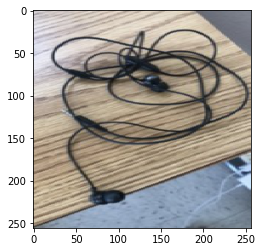

Cardboard 3%
Chemical 4%
E-Waste 1%
Glass 2%
Metal 3%
Organic 5%
Paper 79%
Plastic 3%

RESULT:
Paper
––––––––––––––––


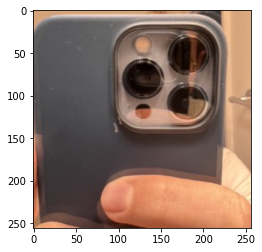

Cardboard 0%
Chemical 2%
E-Waste 59%
Glass 3%
Metal 13%
Organic 3%
Paper 1%
Plastic 19%

RESULT:
E-Waste
––––––––––––––––


In [ ]:
for i in range(sample_set_size):
    img = sample_set[i]
    plt.imshow(img)
    plt.show()
    for label_i in range(len(labels)):
      print(labels[label_i], "{0:.0%}".format(sample_predictions_4[i, label_i]))
    print()
    print("RESULT:")
    print(labels[np.argmax(sample_predictions_4[i])])
    print("––––––––––––––––")

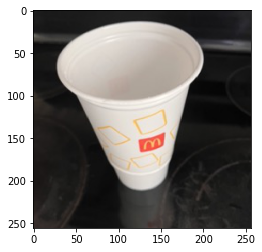

Cardboard 5%
Chemical 1%
E-Waste 36%
Glass 14%
Metal 0%
Organic 23%
Paper 16%
Plastic 5%

RESULT:
E-Waste
––––––––––––––––


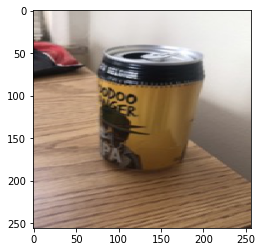

Cardboard 57%
Chemical 10%
E-Waste 9%
Glass 1%
Metal 11%
Organic 1%
Paper 2%
Plastic 8%

RESULT:
Cardboard
––––––––––––––––


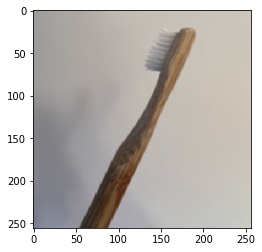

Cardboard 10%
Chemical 7%
E-Waste 3%
Glass 4%
Metal 7%
Organic 14%
Paper 1%
Plastic 54%

RESULT:
Plastic
––––––––––––––––


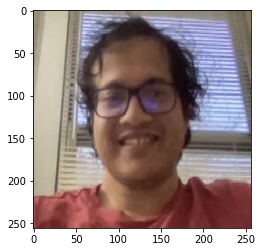

Cardboard 6%
Chemical 2%
E-Waste 10%
Glass 21%
Metal 2%
Organic 7%
Paper 51%
Plastic 1%

RESULT:
Paper
––––––––––––––––


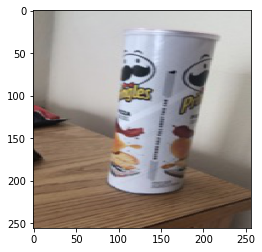

Cardboard 6%
Chemical 7%
E-Waste 1%
Glass 1%
Metal 2%
Organic 11%
Paper 1%
Plastic 71%

RESULT:
Plastic
––––––––––––––––


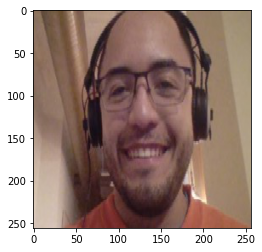

Cardboard 2%
Chemical 5%
E-Waste 35%
Glass 10%
Metal 8%
Organic 28%
Paper 6%
Plastic 5%

RESULT:
E-Waste
––––––––––––––––


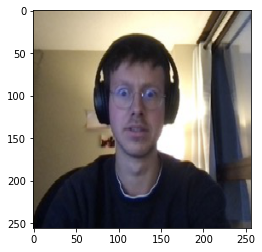

Cardboard 0%
Chemical 16%
E-Waste 54%
Glass 1%
Metal 9%
Organic 12%
Paper 4%
Plastic 3%

RESULT:
E-Waste
––––––––––––––––


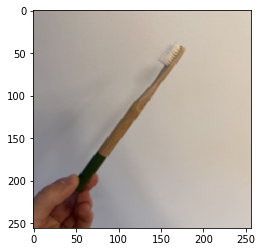

Cardboard 3%
Chemical 1%
E-Waste 5%
Glass 1%
Metal 7%
Organic 3%
Paper 2%
Plastic 78%

RESULT:
Plastic
––––––––––––––––


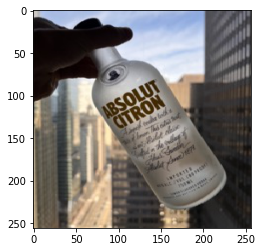

Cardboard 0%
Chemical 3%
E-Waste 7%
Glass 0%
Metal 45%
Organic 19%
Paper 4%
Plastic 21%

RESULT:
Metal
––––––––––––––––


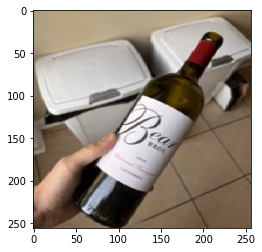

Cardboard 2%
Chemical 1%
E-Waste 20%
Glass 8%
Metal 6%
Organic 12%
Paper 17%
Plastic 34%

RESULT:
Plastic
––––––––––––––––


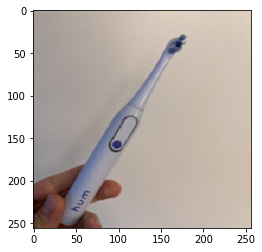

Cardboard 14%
Chemical 3%
E-Waste 5%
Glass 2%
Metal 7%
Organic 4%
Paper 2%
Plastic 65%

RESULT:
Plastic
––––––––––––––––


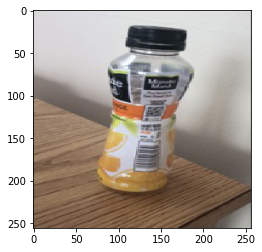

Cardboard 20%
Chemical 8%
E-Waste 9%
Glass 3%
Metal 14%
Organic 4%
Paper 2%
Plastic 39%

RESULT:
Plastic
––––––––––––––––


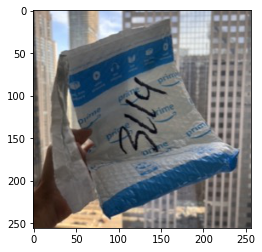

Cardboard 0%
Chemical 1%
E-Waste 27%
Glass 3%
Metal 15%
Organic 12%
Paper 8%
Plastic 34%

RESULT:
Plastic
––––––––––––––––


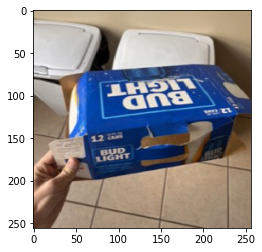

Cardboard 0%
Chemical 2%
E-Waste 85%
Glass 0%
Metal 4%
Organic 1%
Paper 5%
Plastic 2%

RESULT:
E-Waste
––––––––––––––––


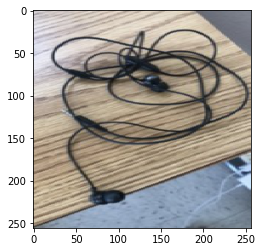

Cardboard 21%
Chemical 3%
E-Waste 4%
Glass 8%
Metal 9%
Organic 2%
Paper 46%
Plastic 7%

RESULT:
Paper
––––––––––––––––


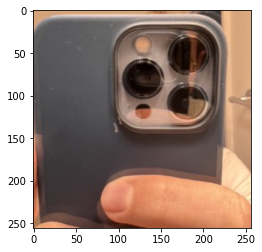

Cardboard 1%
Chemical 2%
E-Waste 90%
Glass 0%
Metal 1%
Organic 2%
Paper 1%
Plastic 2%

RESULT:
E-Waste
––––––––––––––––


In [ ]:
for i in range(sample_set_size):
    img = sample_set[i]
    plt.imshow(img)
    plt.show()
    for label_i in range(len(labels)):
      print(labels[label_i], "{0:.0%}".format(sample_predictions_5[i, label_i]))
    print()
    print("RESULT:")
    print(labels[np.argmax(sample_predictions_5[i])])
    print("––––––––––––––––")

In [ ]:
drive.flush_and_unmount()